# **Исследование архитектур cверточных нейронных сетей на датасетах MNIST и CIFAR**

**Выполнил:** Скоробогатов Кирилл, ИСТ-032м

## Исследование на датасете MNIST

In [ ]:
import torch
import random
import numpy as np
from tqdm import tqdm
from keras.datasets import mnist
import matplotlib.pyplot as plt

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

In [ ]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
X_train = torch.tensor(X_train)
y_train = torch.LongTensor(y_train)
X_test = torch.tensor(X_test)
y_test = torch.LongTensor(y_test)

In [ ]:
X_train.shape

torch.Size([60000, 28, 28])

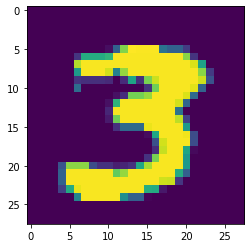

tensor(4)


In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_train[27].reshape(28,28))
plt.show()
print(y_train[26])

In [ ]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [ ]:
X_train[0].shape

torch.Size([1, 28, 28])

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5,
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError
        
        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=5, padding=2)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=1, out_channels=6, kernel_size=3, padding=1)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=1)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       
        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
    
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        
        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))
        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x


In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []
    train_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(20):
        order = np.random.permutation(len(X_train))
        train_batch_loss_history = []
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch) 

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            train_batch_loss_history.append(loss_value.tolist()) 

            optimizer.step()

        net.eval()

        with torch.no_grad(): 
             test_preds = net.forward(X_test)

             test_loss = loss(test_preds, y_test).data.cpu()
             test_loss_history.append(loss(test_preds, y_test).data.cpu())

             #ошибка нейросети по трейновому датасету
             train_loss = np.mean(train_batch_loss_history)
             train_loss_history.append(train_loss)

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)


        res_full =  'epoch_num = {:2d} | train_loss = {:.4f} | test_loss = {:.4f} | test_acc = {:.4f}'.format(epoch, train_loss, test_loss, accuracy)

        print(res_full)
    return test_accuracy_history, test_loss_history


In [ ]:
accuracies_mnist = {}
losses_mnist = {}

In [ ]:
print('Функция активации Tanh, AvgPool2d, 1 конв. слой (ядро 5x5) + 1 конв. слой (ядро 5x5) + 3 полн. слоя')
accuracies_mnist['tanh'], losses_mnist['tanh'] = \
    train(LeNet5(activation='tanh', conv_size=5),
          X_train, y_train, X_test, y_test)

print('_' * 70 + '\n')

print('Функция активации ReLU, AvgPool2d, 1 конв. слой (ядро 5x5) + 1 конв. слой (ядро 5x5) + 3 полн. слоя')
accuracies_mnist['relu'], losses_mnist['relu'] = \
    train(LeNet5(activation='relu', conv_size=5),
          X_train, y_train, X_test, y_test)
    
print('_' * 70 + '\n')

print('Функция активации ReLU, AvgPool2d, 2 конв. слоя (ядро 3x3) + 2 конв. слой (ядро 3x3) + 3 полн. слоя')
accuracies_mnist['relu_3'], losses_mnist['relu_3'] = \
    train(LeNet5(activation='relu', conv_size=3),
          X_train, y_train, X_test, y_test)
    
print('_' * 70 + '\n')

print('Функция активации ReLU, MaxPool2d, 2 конв. слоя (ядро 3x3) + 2 конв. слой (ядро 3x3) + 3 полн. слоя')
accuracies_mnist['relu_3_max_pool'], losses_mnist['relu_3_max_pool'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
          X_train, y_train, X_test, y_test)
    
print('_' * 70 + '\n')

print('Функция активации ReLU, MaxPool2d, батч-нормализация, 2 конв. слоя (ядро 3x3) + 2 конв. слой (ядро 3x3) + 3 полн. слоя')
accuracies_mnist['relu_3_max_pool_bn'], losses_mnist['relu_3_max_pool_bn'] = \
    train(LeNet5(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), 
          X_train, y_train, X_test, y_test)

Функция активации Tanh, AvgPool2d, 1 конв. слой (ядро 5x5) + 1 конв. слой (ядро 5x5) + 3 полн. слоя
epoch_num =  0 | train_loss = 0.3538 | test_loss = 0.1235 | test_acc = 0.9635
epoch_num =  1 | train_loss = 0.1048 | test_loss = 0.0749 | test_acc = 0.9764
epoch_num =  2 | train_loss = 0.0679 | test_loss = 0.0584 | test_acc = 0.9813
epoch_num =  3 | train_loss = 0.0498 | test_loss = 0.0557 | test_acc = 0.9810
epoch_num =  4 | train_loss = 0.0404 | test_loss = 0.0513 | test_acc = 0.9836
epoch_num =  5 | train_loss = 0.0330 | test_loss = 0.0546 | test_acc = 0.9826
epoch_num =  6 | train_loss = 0.0261 | test_loss = 0.0401 | test_acc = 0.9874
epoch_num =  7 | train_loss = 0.0236 | test_loss = 0.0457 | test_acc = 0.9862
epoch_num =  8 | train_loss = 0.0198 | test_loss = 0.0427 | test_acc = 0.9874
epoch_num =  9 | train_loss = 0.0162 | test_loss = 0.0535 | test_acc = 0.9838
epoch_num = 10 | train_loss = 0.0161 | test_loss = 0.0531 | test_acc = 0.9839
epoch_num = 11 | train_loss = 0.0130 | tes

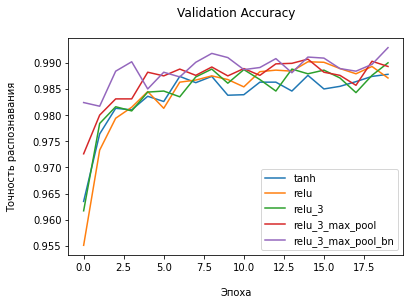

In [ ]:
for experiment_id in accuracies_mnist.keys():
    plt.plot(accuracies_mnist[experiment_id], label=experiment_id)
plt.xlabel('\nЭпоха')
plt.ylabel('Точность распознавания\n')
plt.legend()
plt.title('Validation Accuracy\n');

In [ ]:
acc = []
for experiment_id in accuracies_mnist.keys():
    print(f'Макс. точность для {experiment_id} составила {max(accuracies_mnist[experiment_id])}')
    acc.append(max(accuracies_mnist[experiment_id]))

print('\n' + str(max(acc)))

Макс. точность для tanh составила 0.9878000020980835
Макс. точность для relu составила 0.9901999831199646
Макс. точность для relu_3 составила 0.9899999499320984
Макс. точность для relu_3_max_pool составила 0.9906999468803406
Макс. точность для relu_3_max_pool_bn составила 0.9928999543190002

tensor(0.9929)


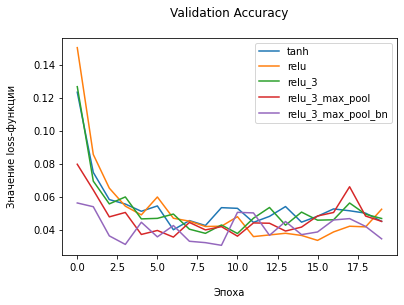

In [ ]:
for experiment_id in losses_mnist.keys():
    plt.plot(losses_mnist[experiment_id], label=experiment_id)
plt.xlabel('\nЭпоха')
plt.ylabel('Значение loss-функции\n')
plt.legend()
plt.title('Validation Accuracy\n');

In [ ]:
loss = []
for experiment_id in losses_mnist.keys():
    print(f'Мин. значение loss-функции для {experiment_id} составило {min(losses_mnist[experiment_id])}')
    loss.append(min(losses_mnist[experiment_id]))

print('\n' + str(min(loss)))

Мин. значение loss-функции для tanh составило 0.04010530561208725
Мин. значение loss-функции для relu составило 0.03366197645664215
Мин. значение loss-функции для relu_3 составило 0.03783809766173363
Мин. значение loss-функции для relu_3_max_pool составило 0.035657286643981934
Мин. значение loss-функции для relu_3_max_pool_bn составило 0.03066987916827202

tensor(0.0307)


## Исследование на датасете CIFAR


In [34]:
import torch
import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from termcolor import colored
import copy
from google.colab import drive
from torch.utils.data import sampler
from torch.autograd import Variable
drive.mount('/content/drive')

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

import warnings
warnings.filterwarnings('ignore')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
from torchvision import datasets, transforms
import torchvision
from torchvision.transforms import Compose 

In [4]:
train_transform = Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(p=0.5),
    # transforms.RandomAffine(0, shear=5, scale=(0.8,1.2)),
    # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomCrop(30, padding=4) ,
    transforms.ToTensor(),
    # transforms.Normalize([0, 0, 0], [1, 1, 1])
])

In [36]:
CIFAR_train = torchvision.datasets.CIFAR10('./', download=True, train=True)
CIFAR_train_transformed = torchvision.datasets.CIFAR10('./', download=True, train=True, transform=train_transform)

CIFAR_train_concat_data = np.concatenate((CIFAR_train.data, CIFAR_train_transformed.data))
CIFAR_train_concat_targets = np.concatenate((CIFAR_train.targets, CIFAR_train_transformed.targets))

CIFAR_test = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=train_transform)



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


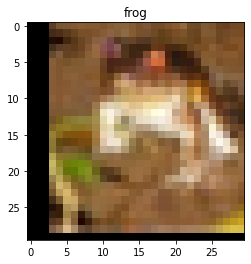

In [6]:
#пример аугментированного изображения
img, label = CIFAR_train_transformed[0]
plt.imshow(img.permute((1, 2, 0)))
plt.title(CIFAR_train.classes[label])
plt.show()

In [37]:
# X_train = torch.FloatTensor(CIFAR_train.data) 
# y_train = torch.LongTensor(CIFAR_train.targets) 

X_train = torch.FloatTensor(CIFAR_train_concat_data) 
y_train = torch.LongTensor(CIFAR_train_concat_targets) 

X_test = torch.FloatTensor(CIFAR_test.data) 
y_test = torch.LongTensor(CIFAR_test.targets)

In [25]:
len(y_train), len(y_test)

(100000, 10000)

In [38]:
X_train = X_train.permute(0, 3, 1, 2)
X_test = X_test.permute(0, 3, 1, 2)

In [9]:
X_train.min(), X_train.max()

(tensor(0.), tensor(255.))

In [39]:
X_train /= 255.
X_test /= 255.

In [ ]:
CIFAR_train.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

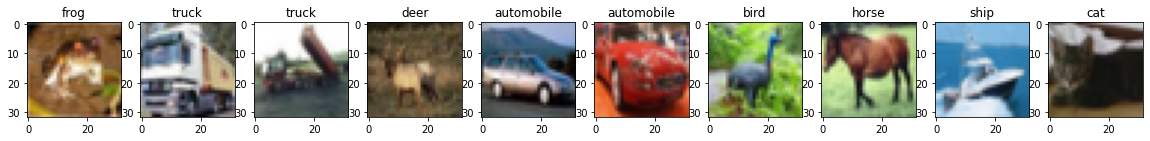

In [12]:
def im_convert(tensor):  
  image = tensor.cpu().clone().detach().numpy() 
  image = image.transpose(1, 2, 0)
  image = image.clip(0, 1)
  return image

import matplotlib.pyplot as plt 
plt.figure(figsize=(20,2)) 
for i in range(10): 
    plt.subplot(1, 10, i+1) 
    # plt.imshow(im_convert(X_train[i])) 
    plt.imshow(X_train[i].cpu().clone().detach().numpy().transpose(1, 2, 0)) 
    plt.title(CIFAR_train.classes[y_train[i]])



### **Класс LeNet5**

In [ ]:
class LeNet5(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(LeNet5, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError


        if conv_size == 5:
            self.conv1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv1_1 = torch.nn.Conv2d(
                in_channels=3, out_channels=6, kernel_size=3, padding=0)
            self.conv1_2 = torch.nn.Conv2d(
                in_channels=6, out_channels=6, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act1 = activation_function
        self.bn1 = torch.nn.BatchNorm2d(num_features=6)
        self.pool1 = pooling_layer
       

        if conv_size == 5:
            self.conv2 = self.conv2 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=5, padding=0)
        elif conv_size == 3:
            self.conv2_1 = torch.nn.Conv2d(
                in_channels=6, out_channels=16, kernel_size=3, padding=0)
            self.conv2_2 = torch.nn.Conv2d(
                in_channels=16, out_channels=16, kernel_size=3, padding=0)
        else:
            raise NotImplementedError

        self.act2 = activation_function
        self.bn2 = torch.nn.BatchNorm2d(num_features=16)
        self.pool2 = pooling_layer
        
        
        self.fc1 = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3 = activation_function
        self.droput1 = torch.nn.Dropout(p=0.5)
       
        self.fc2 = torch.nn.Linear(120, 84)
        self.act4 = activation_function
        self.droput2 = torch.nn.Dropout(p=0.3)

        self.fc3 = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        if self.conv_size == 5:
            x = self.conv1(x)
        elif self.conv_size == 3:
            x = self.conv1_2(self.conv1_1(x))
        x = self.act1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
        if self.conv_size == 5:
            x = self.conv2(x)
        elif self.conv_size == 3:
            x = self.conv2_2(self.conv2_1(x))
        x = self.act2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        
        x = self.fc1(x)
        x = self.act3(x)
        x = self.droput1(x)
       
        x = self.fc2(x)
        x = self.act4(x)
        x = self.droput2(x)
        x = self.fc3(x)
        
        return x


### **Класс CIFAR10**

In [ ]:
class CIFAR10(torch.nn.Module):
    def __init__(self,
                 activation='tanh',
                 pooling='avg',
                 conv_size=5, 
                 use_batch_norm=False):
        super(CIFAR10, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

  
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=86, kernel_size=3, padding=1) #32x32 -> 32x32
        self.act1 = activation_function
        # self.droput1 = torch.nn.Dropout(p=0.1)
        self.bn1 = torch.nn.BatchNorm2d(num_features=86)
        self.pool1 = pooling_layer #32x32 -> 16x16

        self.conv2 = torch.nn.Conv2d(in_channels=86, out_channels=128, kernel_size=3, padding=1) #16x16 -> 16x16
        self.act2 = activation_function
        # self.droput2 = torch.nn.Dropout(p=0.5)
        self.bn2 = torch.nn.BatchNorm2d(num_features=128)
        self.pool2 = pooling_layer  #16x16 -> 8x8
           
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) #8x8 -> 8x8
        self.act3 = activation_function
        # self.droput3 = torch.nn.Dropout(p=0.5)
        self.bn3 = torch.nn.BatchNorm2d(num_features=256)
        self.pool3 = pooling_layer #8x8 -> 4x4

        self.fc1 = torch.nn.Linear(4*4*256, 2048) #4096 -> 2048
        self.act4 = activation_function
        self.droput4 = torch.nn.Dropout(p=0.5)
       
        self.fc2 = torch.nn.Linear(2048, 1612)
        self.act5 = activation_function
        self.droput5 = torch.nn.Dropout(p=0.3)

        # self.fc3 = torch.nn.Linear(1612, 556)
        # self.act6 = activation_function
        # self.droput6 = torch.nn.Dropout(p=0.2)

        # self.fc4 = torch.nn.Linear(556, 230)
        # self.act7 = activation_function
        # self.droput7 = torch.nn.Dropout(p=0.3)

        self.fc5 = torch.nn.Linear(1612, 10)
    
    def forward(self, x):
       
        x = self.conv1(x)
        x = self.act1(x)
        # x = self.droput1(x)
        if self.use_batch_norm:
            x = self.bn1(x)
        x = self.pool1(x)
        
      
        x = self.conv2(x)
        x = self.act2(x)
        # x = self.droput2(x)
        if self.use_batch_norm:
            x = self.bn2(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = self.act3(x)
        # x = self.droput3(x)
        if self.use_batch_norm:
            x = self.bn3(x)
        x = self.pool3(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act4(x)
        x = self.droput4(x)
       
        x = self.fc2(x)
        x = self.act5(x)
        x = self.droput5(x)

        # x = self.fc3(x)
        # x = self.act6(x)
        # x = self.droput6(x)

        # x = self.fc4(x)
        # x = self.act7(x)
        # x = self.droput7(x)

        x = self.fc5(x)
        
        return x

net = CIFAR10()

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.01)

# lenet5 = LeNet5()
# lenet5.apply(init_weights)

# cifar10 = CIFAR10()
# cifar10.apply(init_weights)

### **Класс CIFAR10 PRO**

In [15]:
class CIFAR10PRO(torch.nn.Module):
    def __init__(self,
                 activation='relu',
                 pooling='max',
                 conv_size=3, 
                 use_batch_norm=True):
        super(CIFAR10PRO, self).__init__()
        
        self.conv_size = conv_size
        self.use_batch_norm = use_batch_norm
        
        if activation == 'tanh':
            activation_function = torch.nn.Tanh()
        elif activation == 'relu':
            activation_function  = torch.nn.ReLU()
        else:
            raise NotImplementedError
            
        if pooling == 'avg':
            pooling_layer = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        elif pooling == 'max':
            pooling_layer  = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        else:
            raise NotImplementedError

  
        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1) #32x32 -> 32x32
        self.act1 = activation_function
        # self.droput1 = torch.nn.Dropout(p=0.2)
       
        self.conv1_2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1) #32x32 -> 32x32
        self.act2 = activation_function
        # self.droput2 = torch.nn.Dropout(p=0.2)
       
        self.bn1 = torch.nn.BatchNorm2d(num_features=64)
        self.pool1 = pooling_layer #32x32 -> 16x16

        # ===============================

        self.conv2_1 = torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1) #16x16 -> 16x16
        self.act3 = activation_function
        # self.droput3 = torch.nn.Dropout(p=0.2)
       
        self.conv2_2 = torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1) #16x16 -> 16x16
        self.act4 = activation_function
        # self.droput4 = torch.nn.Dropout(p=0.2)
       
        self.bn2 = torch.nn.BatchNorm2d(num_features=128)
        self.pool2 = pooling_layer #16x16 -> 8x8

        # ===============================

        self.conv3_1 = torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1) #8x8-> 8x8
        self.act5 = activation_function
        # self.droput5 = torch.nn.Dropout(p=0.2)
       
        self.conv3_2 = torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1) #8x8 -> 8x8
        self.act6 = activation_function
        # self.droput6 = torch.nn.Dropout(p=0.2)
       
        self.bn3 = torch.nn.BatchNorm2d(num_features=256)
        self.pool3 = pooling_layer #8x8 -> 4x4

        # ===============================

        self.fc1 = torch.nn.Linear(4*4*256, 2048) #2048 -> 1024
        self.act7 = activation_function
        self.droput7 = torch.nn.Dropout(p=0.2)
       
        self.fc2 = torch.nn.Linear(2048, 1024)
        self.act8 = activation_function
        self.droput8 = torch.nn.Dropout(p=0.2)

        self.fc3 = torch.nn.Linear(1024, 10)
    
    def forward(self, x):
       
       
        x = self.conv1_1(x)
        x = self.act1(x)
        # x = self.droput1(x)

        x = self.conv1_2(x)
        x = self.act2(x)
        # x = self.droput2(x)

        x = self.bn1(x)
        x = self.pool1(x)


        x = self.conv2_1(x)
        x = self.act3(x)
        # x = self.droput3(x)

        x = self.conv2_2(x)
        x = self.act4(x)
        # x = self.droput4(x)

        x = self.bn2(x)
        x = self.pool1(x)


        x = self.conv3_1(x)
        x = self.act5(x)
        # x = self.droput5(x)

        x = self.conv3_2(x)
        x = self.act6(x)
        # x = self.droput6(x)

        x = self.bn3(x)
        x = self.pool1(x)
      
       
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act7(x)
        x = self.droput7(x)
       
        x = self.fc2(x)
        x = self.act8(x)
        x = self.droput8(x)

        x = self.fc3(x)
        
        return x

net_pro = CIFAR10PRO()

In [ ]:
def init_weights(m):
    if type(m) == torch.nn.Linear:
        torch.nn.init.xavier_normal(m.weight)
        m.bias.data.fill_(0.01)

# lenet5 = LeNet5()
# lenet5.apply(init_weights)

cifar10 = CIFAR10PRO()
cifar10.apply(init_weights)

CIFAR10PRO(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

### **train_default function**

In [ ]:
def train_default(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    
    batch_size = 100

    test_accuracy_history = []
    test_loss_history = []

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(30):
        order = np.random.permutation(len(X_train))
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            optimizer.step()
            
            X_batch

        net.eval()
        with torch.no_grad():
             test_preds = net.forward(X_test)

        test_loss_history.append(loss(test_preds, y_test).data.cpu())

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
        test_accuracy_history.append(accuracy)

        print(accuracy)
    del net
    return test_accuracy_history, test_loss_history


### **train function**

In [ ]:
def train(net, X_train, y_train, X_test, y_test):
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    net = net.to(device)
    loss = torch.nn.CrossEntropyLoss()
    # optimizer = torch.optim.Adam(net.parameters(), lr=1.0e-3)
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum = 0.9, nesterov=False)
    batch_size = 350

    test_accuracy_history = []
    test_loss_history = []
    train_loss_history = []
    
    models = {}
    
    best_test_loss = float('inf')
    best_epoch_i = 0
    early_stopping_patience = 65
    best_lenet5 = copy.deepcopy(net)

    X_test = X_test.to(device)
    y_test = y_test.to(device)

    for epoch in range(10):
        order = np.random.permutation(len(X_train))
        train_batch_loss_history = [] 
        for start_index in range(0, len(X_train), batch_size):
            optimizer.zero_grad()
            net.train()

            batch_indexes = order[start_index:start_index+batch_size]

            X_batch = X_train[batch_indexes].to(device)
            y_batch = y_train[batch_indexes].to(device)

            preds = net.forward(X_batch)

            loss_value = loss(preds, y_batch)
            loss_value.backward()

            train_batch_loss_history.append(loss_value.tolist()) 

            optimizer.step()
            
        net.eval()
        # остановка autograd от отслежвания истории на тензорах с 
        # .requires_grad=True с помощью обертывания блока кода в with torch.no_grad():
        with torch.no_grad():
             test_preds = net.forward(X_test)
        
             test_loss = loss(test_preds, y_test).data.cpu()

             #ошибка нейросети по трейновому датасету
             train_loss = np.mean(train_batch_loss_history)
             

        accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()


        print(f'epoch_num = {epoch:2d} | train_loss = {train_loss:.4f} | test_loss = {test_loss:.4f} | test_acc = {accuracy:.4f}')
        # print(f'epoch_num = {epoch:2d} | test_loss = {test_loss:.4f} | test_acc = {accuracy:.4f}')
        
        test_loss_history.append(test_loss)
        train_loss_history.append(train_loss)
        test_accuracy_history.append(accuracy)

        models[f'{epoch}'] = copy.deepcopy(net)

        if test_loss < best_test_loss:
            best_epoch_i = epoch
            best_test_loss = test_loss
            # best_lenet5 = copy.deepcopy(net)
            # test_loss_history.append(test_loss)
            # train_loss_history.append(train_loss)
            # test_accuracy_history.append(accuracy)
            # print(colored('Новая лучшая модель!', 'green'))
        elif epoch - best_epoch_i > early_stopping_patience:
            print(colored(f'Модель не улучшилась за последние {early_stopping_patience} эпох, прекращаем обучение', 'red'))
            break
    del net
    return models, test_accuracy_history, test_loss_history


### **Процесс обучения**

In [13]:
accuracies_cifar = {}
losses_cifar = {}

In [ ]:
# print('Функция активации Tanh, AvgPool2d, 1 конв. слой (ядро 5x5) + 1 конв. слой (ядро 5x5) + 3 полн. слоя')
# best_lenet_tanh, accuracies_cifar['tanh'], losses_cifar['tanh'] = \
#     train(LeNet5(activation='tanh', conv_size=5), X_train, y_train, X_test, y_test)

# print('Функция активации ReLU, AvgPool2d, 1 конв. слой (ядро 5x5) + 1 конв. слой (ядро 5x5) + 3 полн. слоя')
# best_lenet_relu, accuracies_cifar['relu'], losses_cifar['relu'] = \
#     train(LeNet5(activation='relu', conv_size=5),
#           X_train, y_train, X_test, y_test)
    
# print('Функция активации ReLU, AvgPool2d, 2 конв. слоя (ядро 3x3) + 2 конв. слой (ядро 3x3) + 3 полн. слоя')
# best_lenet_relu_3, accuracies_cifar['relu_3'], losses_cifar['relu_3'] = \
#     train(LeNet5(activation='relu', conv_size=3),
#           X_train, y_train, X_test, y_test)
    
# print('Функция активации ReLU, MaxPool2d, 2 конв. слоя (ядро 3x3) + 2 конв. слой (ядро 3x3) + 3 полн. слоя')
# best_lenet_relu_3_max_pool, accuracies_cifar['relu_3_max_pool'], losses_cifar['relu_3_max_pool'] = \
#     train(LeNet5(activation='relu', conv_size=3, pooling='max'), 
#           X_train, y_train, X_test, y_test)
    
# print('Функция активации ReLU, MaxPool2d, батч-нормализация, 2 конв. слоя (ядро 3x3) + 2 конв. слой (ядро 3x3) + 3 полн. слоя')  



models_dict, accuracies_cifar['relu_3_max_pool_bn'], losses_cifar['relu_3_max_pool_bn'] = \
    train(CIFAR10PRO(activation='relu', conv_size=3, pooling='max', use_batch_norm=True), X_train, y_train, X_test, y_test)

epoch_num =  0 | train_loss = 1.1373 | test_loss = 0.8389 | test_acc = 0.7069
epoch_num =  1 | train_loss = 0.5350 | test_loss = 0.6447 | test_acc = 0.7772
epoch_num =  2 | train_loss = 0.2901 | test_loss = 0.7261 | test_acc = 0.7759
epoch_num =  3 | train_loss = 0.1363 | test_loss = 0.8514 | test_acc = 0.7900
epoch_num =  4 | train_loss = 0.0692 | test_loss = 0.8722 | test_acc = 0.8014
epoch_num =  5 | train_loss = 0.0381 | test_loss = 0.9886 | test_acc = 0.7933
epoch_num =  6 | train_loss = 0.0263 | test_loss = 0.9489 | test_acc = 0.8120
epoch_num =  7 | train_loss = 0.0120 | test_loss = 1.0229 | test_acc = 0.8186
epoch_num =  8 | train_loss = 0.0055 | test_loss = 1.0310 | test_acc = 0.8159
epoch_num =  9 | train_loss = 0.0037 | test_loss = 1.0739 | test_acc = 0.8178


**Сохранение лучшей модели**

In [ ]:
best_model_8052 = models_dict.get('5')
best_model_8208 = models_dict.get('8')

In [ ]:
# torch.save(model.state_dict(), PATH)

# torch.save(best_model_8052.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models_cifar10/best_model_sgd_8052.pth')
# torch.save(best_model_8208.state_dict(), '/content/drive/MyDrive/Colab Notebooks/models_cifar10/best_model_sgd_8208.pth')

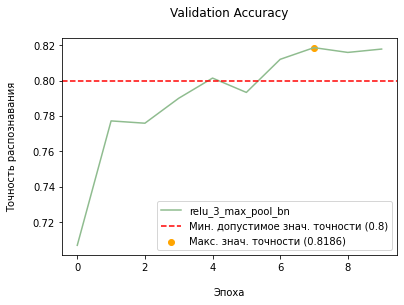

In [ ]:
for experiment_id in accuracies_cifar.keys():
    max_accuracy = max(accuracies_cifar[experiment_id])
    index_max_accuracy = accuracies_cifar[experiment_id].index(max_accuracy)
    plt.plot(accuracies_cifar[experiment_id], label=experiment_id, color='darkseagreen')
    plt.scatter(index_max_accuracy, max_accuracy, color='orange', marker='o', label =f'Макс. знач. точности ({max_accuracy:.4f})')

plt.axhline(0.80, color='r', linestyle='--', label='Мин. допустимое знач. точности (0.8)')
plt.legend()
plt.xlabel('\nЭпоха')
plt.ylabel('Точность распознавания\n')
plt.title('Validation Accuracy\n');

In [ ]:
acc = []
for experiment_id in accuracies_cifar.keys():
    print(f'Макс. точность для {experiment_id} составила {max(accuracies_cifar[experiment_id])}')
    acc.append(max(accuracies_cifar[experiment_id]))

print('\n' + str(max(acc)))

Макс. точность для relu_3_max_pool_bn составила 0.8185999989509583

tensor(0.8186)


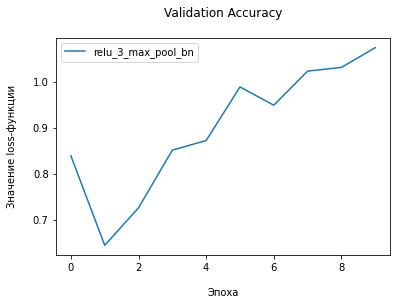

In [ ]:
for experiment_id in losses_cifar.keys():
    plt.plot(losses_cifar[experiment_id], label=experiment_id)
plt.legend()
plt.xlabel('\nЭпоха')
plt.ylabel('Значение loss-функции\n')
plt.legend()
plt.title('Validation Accuracy\n');

In [ ]:
loss = []
for experiment_id in losses_cifar.keys():
    print(f'Мин. значение loss-функции для {experiment_id} составило {min(losses_cifar[experiment_id])}')
    loss.append(min(losses_cifar[experiment_id]))

print('\n' + str(min(loss)))

Мин. значение loss-функции для relu_3_max_pool_bn составило 0.6446638107299805

tensor(0.6447)


### **Проверка верности распознавания**

**Загрузка модели**

In [16]:
best_model = CIFAR10PRO()
best_model.load_state_dict(torch.load('/content/drive/MyDrive/Colab Notebooks/models_cifar10/best_model_sgd_8208.pth'))
best_model.eval()

CIFAR10PRO(
  (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act2): ReLU()
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act3): ReLU()
  (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act4): ReLU()
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act5): ReLU()
  (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (act6): ReLU()
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affi

In [33]:
X_test.shape
print(X_test.shape)

best_model.to('cpu')
X_test = X_test.to('cpu')
y_test = y_test.to('cpu')

torch.Size([4, 3, 32, 32])


torch.Size([1, 3, 32, 32])


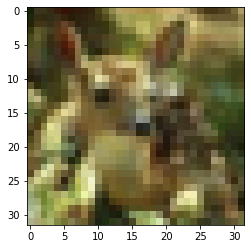

Прогноз модели: deer, правильная метка: deer 
id = 9461


In [42]:
id = 9461


X_to_predict = X_test[id].reshape(1,3,32,32)

print(X_to_predict.shape)
###########
predicted_number = best_model.forward(X_to_predict).detach().numpy()
# plt.imshow(X_to_predict.reshape(1,3,32,32))
plt.imshow(transforms.ToPILImage()(X_to_predict.reshape(3, 32,32)))

plt.show()

print( '='* 45 + f"\nПрогноз модели: { CIFAR_train.classes[np.argmax(predicted_number)]}, правильная метка: { CIFAR_train.classes[y_test[id]]} \n" + '='* 45) 

print(f'id = {id}')

In [32]:
y_test

tensor([3, 5, 1, 7])

In [30]:
test_transform = Compose([
    transforms.ToTensor()
])

CIFAR_test_tensor = torchvision.datasets.CIFAR10('./', download=True, train=False, transform=test_transform)
test_loader = torch.utils.data.DataLoader(CIFAR_test_tensor, batch_size=12)

arr = []

for (X_test, y_test) in test_loader:
    arr.extend(best_model.forward(X_test).detach().numpy())

test_preds = torch.Tensor(arr)

Files already downloaded and verified


In [40]:
# в данной переменной сохранены id всех объектов, которые модель неправильного предсказала                          
non_correct_ids = [id for (id,pred) in enumerate(test_preds.argmax(dim=1) != y_test) if pred]

In [41]:
# Кол-во неверно пресказанных объектов
print(f'Кол-во неверно пресказанных объектов: {len(non_correct_ids)}')

Кол-во неверно пресказанных объектов: 1792


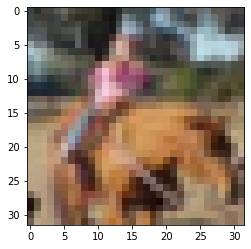

Прогноз модели: deer, правильная метка: horse 
id = 9635


In [ ]:
# 9635 random.choice выбирает случайный id из скиска non_correct_ids по которому выбирается объект для прогноза из тестовой выборки
id = random.choice(non_correct_ids)
X_to_predict = X_test[id].reshape(1,*X_test[id].shape)
###########
predicted_number = best_model.forward(X_to_predict).detach().numpy()
plt.imshow(transforms.ToPILImage()(X_to_predict.reshape(3, 32,32)))
plt.show()
print( '='* 45 + f"\nПрогноз модели: { CIFAR_train.classes[np.argmax(predicted_number)]}, правильная метка: { CIFAR_train.classes[y_test[id]]} \n" + '='* 45) 
print(f'id = {id}')

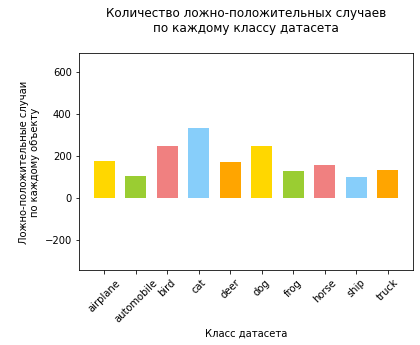

In [43]:
import matplotlib.pyplot as plt

distance = 150
classes = 10
x = list(range(0,classes*distance,distance))

perc = np.zeros(classes).astype(int)
for id in non_correct_ids:
  perc[y_test[id]] += 1
  
width=100
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','orange','gold','yellowgreen', 'lightcoral', 'lightskyblue','orange']
plt.xticks(x,CIFAR_train.classes, rotation=45)
plt.bar(x,perc,width,align='center', color=colors)
plt.ylabel('\nЛожно-положительные случаи\nпо каждому объекту')
plt.xlabel('Класс датасета')
plt.title('Количество ложно-положительных случаев\nпо каждому классу датасета\n')
plt.axis('equal')
plt.show()

